In [12]:
import os
import glob
import rosbag
import rosbag_pandas
import numpy as np
import pandas as pd
import timeit
import cv2
import time 

import matplotlib.pyplot as plt
from cv_bridge import CvBridge, CvBridgeError
from pypeln import thread as th

In [13]:
BAG_FOLDER = '/home/francesco/Desktop/carino/vaevictis/data/'

In [14]:
files = glob.glob(BAG_FOLDER + '/*.bag')
files

['/home/francesco/Desktop/carino/vaevictis/data/1542273511.7655113.bag']

In [15]:
filename2map = pd.read_csv('/home/francesco/Documents/Master-Thesis/core/filename2map.csv')
filename2map

,Unnamed: 0,filename,map
0,0,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
1,1,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
2,2,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
3,3,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
4,4,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
5,5,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
6,6,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
7,7,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
8,8,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...
9,9,/home/francesco/Desktop/carino/vaevictis/data/...,/home/francesco/Documents/Master-Thesis/core/w...


In [64]:
def bag2df(file_name):
    df = None
    try:
        df = rosbag_pandas.bag_to_dataframe(file_name) 
    except TypeError:
        print(file_name)
    world_file = filename2map[filename2map.filename == file_name].map.values[0]
    map_name = world_file.split('/')[-1].split('.')[0]
    return (map_name, df )

In [65]:
stage = th.map(bag2df, files, workers = 16)

data = list(stage)

In [66]:
len(data)

1

In [99]:
df = pd.concat([df for (m, df) in data])

In [9]:
# bag = rosbag.Bag(files[2])
# bridge = CvBridge()

# for topic, msg, t in bag.read_messages(topics=['frontal_camera']):
#     img = bridge.imgmsg_to_cv2(msg, "bgr8")
#     cv2.imshow('img', img)
#     print(img.shape)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
# bag.close()

In [ ]:
map_path, df = bag2df(files[1])

In [102]:
# for data in camera_data:
#     bridge.imgmsg_to_cv2(data, "bgr8")

In [22]:
%matplotlib notebook

In [57]:
def create_trace_world(df, res=0.5):
    x = df.pose__pose_position_x
    y = df.pose__pose_position_y

    X = np.arange(-5, 5,res)
    Y = np.arange(-5, 5, res)
    world = np.zeros((X.shape[0], Y.shape[0]))
   
    for x_, y_ in zip(x,y):
        xi = np.digitize(x_, X) - 1
        yi = np.digitize(y_, Y) - 1
        world[xi, yi] += 1    

    world /= len(x)
    world = world.T
    
    return world, X, Y

In [58]:
def create2dtrace(df):
    import ipympl
    import matplotlib.pyplot as plt
    from mpl_toolkits import mplot3d
    
    fig = plt.figure()

    plt.rcParams['figure.figsize'] = [8, 5]
    plt.imshow(world * 255)
    plt.show()

In [59]:
def create3dtrace(world,X, Y,map_name):
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.colors as mcolors
    import matplotlib
    
    
    Xm, Ym = np.meshgrid(X, Y)
    Z = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}.png'.format(map_name))
    Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
    Z = cv2.resize(Z, Xm.shape, cv2.INTER_CUBIC) 
    
    # fourth dimention - colormap
    # create colormap according to x-value (can use any 50x50 array)
    color_dimension = world # change to desired fourth dimension
    minn, maxx = color_dimension.min(), color_dimension.max()
    norm = matplotlib.colors.Normalize(minn, maxx)
    m = plt.cm.ScalarMappable(norm=norm)
    m.set_array([])
    fcolors = m.to_rgba(color_dimension)
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(Xm, Ym, Z,  facecolors=fcolors, linewidth=0.1)
    plt.show()

In [60]:
world, X, Y = create_trace_world(data[0][1])

<IPython.core.display.Javascript object>


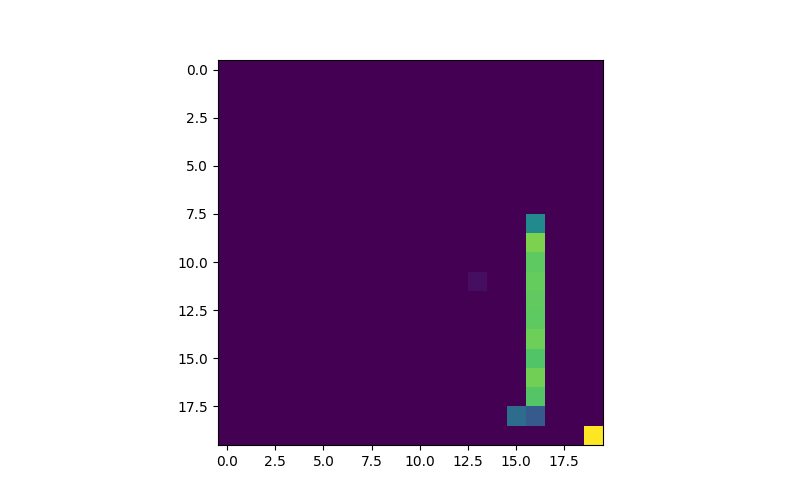

In [61]:
create2dtrace(world)

In [67]:
data[0][0]

'holes3'

<IPython.core.display.Javascript object>


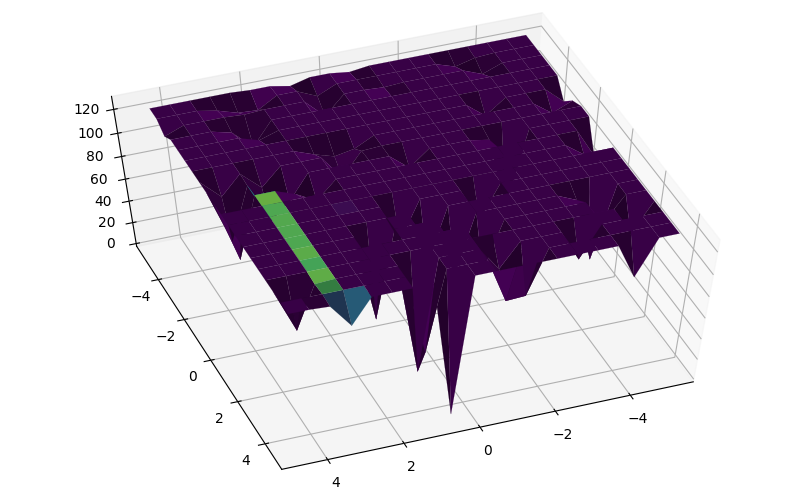

In [68]:
create3dtrace(world, X, Y, data[0][0])

In [83]:
Xm, Ym = np.meshgrid(X, Y)
Z = cv2.imread('/home/francesco/Documents/Master-Thesis/core/maps/{}.png'.format(map_name))
Z = cv2.cvtColor(Z, cv2.COLOR_BGR2GRAY)
Z = cv2.resize(Z, Xm.shape, cv2.INTER_CUBIC) 

In [84]:
print(Xm.shape)

(20, 20)


In [85]:
world.shape, Xm.shape, Ym.shape

((20, 20), (20, 20), (20, 20))

In [86]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib

In [87]:
# fourth dimention - colormap
# create colormap according to x-value (can use any 50x50 array)
color_dimension = world # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm)
m.set_array([])
fcolors = m.to_rgba(color_dimension)

<IPython.core.display.Javascript object>


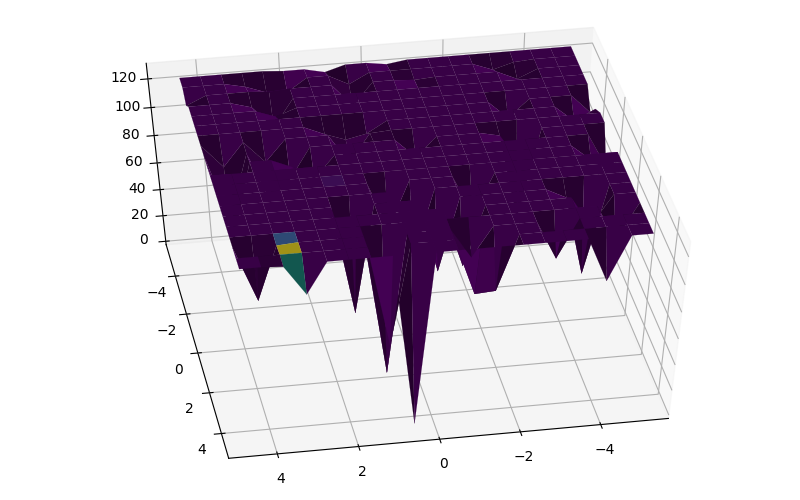

In [88]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Xm, Ym, Z,  facecolors=fcolors, linewidth=0.1)
plt.show()

In [ ]:
querry = '/home/francesco/Documents/krock-sim/krock/krock2_ros/map_generation/querry.npy'